# VANGUARD AB TEST


## METADATA HELP

This comprehensive set of fields will guide your analysis, helping you unravel the intricacies of client behavior and preferences.

- **client_id**: Every client’s unique ID.
- **variation**: Indicates if a client was part of the experiment.
- **visitor_id**: A unique ID for each client-device combination.
- **visit_id**: A unique ID for each web visit/session.
- **process_step**: Marks each step in the digital process.
- **date_time**: Timestamp of each web activity.
- **clnt_tenure_yr**: Represents how long the client has been with Vanguard, measured in years.
- **clnt_tenure_mnth**: Further breaks down the client’s tenure with Vanguard in months.
- **clnt_age**: Indicates the age of the client.
- **gendr**: Specifies the client’s gender.
- **num_accts**: Denotes the number of accounts the client holds with Vanguard.
- **bal**: Gives the total balance spread across all accounts for a particular client.
- **calls_6_mnth**: Records the number of times the client reached out over a call in the past six months.
- **logons_6_mnth**: Reflects the frequency with which the client logged onto Vanguard’s platform over the last six months.


In [76]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
from cleaning import *
from mining import *
from db_handling import *
from analysis import *
import pandas as pd
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [78]:
# Load environment variables
load_dotenv()

True

### Load Configuration

In [79]:
# Load config.yaml
config = parse_config()

{'database_name': 'vanguard_ab', 'refresh_db': False, 'tables': {'clients': {'sources': [{'path': 'data/df_final_demo.txt', 'url': 'https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt'}], 'separator': ',', 'dropna': True, 'columns': {'client_id': {'original_name': 'client_id', 'data_type': 'INTEGER', 'primary_key': True, 'pandas_dtype': 'int64'}, 'client_since_month': {'original_name': 'clnt_tenure_mnth', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'client_since_year': {'original_name': 'clnt_tenure_yr', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'client_age': {'original_name': 'clnt_age', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'}, 'gender': {'original_name': 'gendr', 'data_type': 'CHAR(1)', 'pandas_dtype': 'category', 'valid_categories': ['U', 'M', 'F'], 'fallback_category': 'U'}, 'number_of_accounts': {'original_name': 'num_accts', 'data_type': 'FLOAT', 'pandas_dtype': 'int64'},

## Data Mining

In [80]:
# Creates a dictionary of all imported dataframes
dataframes = { name:import_data_from_config(config, name) for name in config['tables']}

## Data Cleaning

In [81]:
# Rename columns
dataframes = rename_columns(dataframes, config)

In [82]:
# Select columns
dataframes = select_columns(dataframes, config)

In [83]:
display_dataFrames(dataframes,'head','shape','describe')

clients:
clients - Head:


,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,6.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,7.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,5.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,16.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,12.0,33.0,F,2.0,103671.75,0.0,3.0


clients - Shape:


(70609, 9)

clients - Describe:


,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
count,7.060900e+04,70595.000000,70595.000000,70594.000000,70595,70595.000000,7.059500e+04,70595.000000,70595.000000
unique,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,24122,NaN,NaN,NaN,NaN
mean,5.004992e+06,150.659367,12.052950,46.442240,NaN,2.255528,1.474452e+05,3.382478,5.566740
std,2.877278e+06,82.089854,6.871819,15.591273,NaN,0.534997,3.015087e+05,2.236580,2.353286
min,1.690000e+02,33.000000,2.000000,13.500000,NaN,1.000000,1.378942e+04,0.000000,1.000000
25%,2.519329e+06,82.000000,6.000000,32.500000,NaN,2.000000,3.734683e+04,1.000000,4.000000
50%,5.016978e+06,136.000000,11.000000,47.000000,NaN,2.000000,6.333290e+04,3.000000,5.000000
75%,7.483085e+06,192.000000,16.000000,59.000000,NaN,2.000000,1.375449e+05,6.000000,7.000000


experiment:
experiment - Head:


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


experiment - Shape:


(70609, 2)

experiment - Describe:


,client_id,variation
count,7.060900e+04,50500
unique,NaN,2
top,NaN,Test
freq,NaN,26968
mean,5.004992e+06,NaN
std,2.877278e+06,NaN
min,1.690000e+02,NaN
25%,2.519329e+06,NaN
50%,5.016978e+06,NaN
75%,7.483085e+06,NaN


visits:
visits - Head:


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


visits - Shape:


(755405, 5)

visits - Describe:


,client_id,visitor_id,visit_id,process_step,date_time
count,7.554050e+05,755405,755405,755405,755405
unique,NaN,130236,158095,5,629363
top,NaN,722943003_3441581446,875138661_34710212496_881092,start,2017-05-02 10:07:41
freq,NaN,104,104,243945,24
mean,5.013632e+06,NaN,NaN,NaN,NaN
std,2.879152e+06,NaN,NaN,NaN,NaN
min,1.690000e+02,NaN,NaN,NaN,NaN
25%,2.519882e+06,NaN,NaN,NaN,NaN
50%,5.033441e+06,NaN,NaN,NaN,NaN
75%,7.496063e+06,NaN,NaN,NaN,NaN


### Separation

In [84]:
client_df = dataframes['clients']
experiment_df = dataframes['experiment']
visits_df = dataframes['visits']
display (client_df, experiment_df, visits_df)

,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,6.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,7.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,5.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,16.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,12.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
70604,7993686,56.0,4.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,12.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,16.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,21.0,68.0,M,3.0,475114.69,4.0,4.0


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


In [85]:
display(visits_df.describe(include='all'))

,client_id,visitor_id,visit_id,process_step,date_time
count,7.554050e+05,755405,755405,755405,755405
unique,NaN,130236,158095,5,629363
top,NaN,722943003_3441581446,875138661_34710212496_881092,start,2017-05-02 10:07:41
freq,NaN,104,104,243945,24
mean,5.013632e+06,NaN,NaN,NaN,NaN
std,2.879152e+06,NaN,NaN,NaN,NaN
min,1.690000e+02,NaN,NaN,NaN,NaN
25%,2.519882e+06,NaN,NaN,NaN,NaN
50%,5.033441e+06,NaN,NaN,NaN,NaN
75%,7.496063e+06,NaN,NaN,NaN,NaN


In [86]:
cleaning = [{"step" : "Raw data", "count" : visits_df['client_id'].nunique()}]

display(cleaning)

[{'step': 'Raw data', 'count': 120157}]

In [87]:
# drop the nulls from clients, but keep the list of the drops

nulls_client_id = client_df[client_df.isna().any(axis=1)]['client_id']
nulls_client_id

4164     7402828
8316      355337
8677     8412164
9583     4666211
13444    2222915
18066    4876926
25961    5277910
28432    7616759
35323    8191345
43518    1227228
46076    8611797
47189    5144725
49846    1037867
63701    1618749
66219    6021001
Name: client_id, dtype: int64

In [88]:
client_df = client_df.dropna(axis=0)
client_df

,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,6.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,7.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,5.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,16.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,12.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
70604,7993686,56.0,4.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,12.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,16.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,21.0,68.0,M,3.0,475114.69,4.0,4.0


In [89]:
display(experiment_df['variation'].value_counts(dropna = False))
# keep NaN for general analysis of clients, but drop them from everywhere for test analysis

variation
Test       26968
Control    23532
NaN        20109
Name: count, dtype: int64

In [90]:
# client_df, experiment_df, visit_df -> for general analysis
# new_client_df, new_experiment_df, new_visit_dfn -> for test/control analysis   experiment_df_null = 
nulls_in_experiment = experiment_df[experiment_df.isna().any(axis=1)]['client_id']
nulls_in_experiment

50500    5459747
50501    8031000
50502    1847030
50503    9713157
50504    7775828
          ...   
70604    2443347
70605    8788427
70606     266828
70607    1266421
70608    9895983
Name: client_id, Length: 20109, dtype: int64

In [91]:
# new df removing client ID that are null in experiment

display(experiment_df.count())
new_experiment_df = experiment_df[~experiment_df['client_id'].isin(nulls_in_experiment)]
display(new_experiment_df.count())

new_experiment_df = new_experiment_df[~new_experiment_df['client_id'].isin(nulls_client_id)]
display(new_experiment_df.count())
display(new_experiment_df.isna().sum())



client_id    70609
variation    50500
dtype: int64

client_id    50500
variation    50500
dtype: int64

client_id    50487
variation    50487
dtype: int64

client_id    0
variation    0
dtype: int64

In [92]:
display(visits_df)
new_visits_df = visits_df[~visits_df['client_id'].isin(nulls_in_experiment)]
display(new_visits_df)
display(new_visits_df.isna().sum())

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


client_id       0
visitor_id      0
visit_id        0
process_step    0
date_time       0
dtype: int64

In [93]:
cleaning.append({"step" : "Drop nulls", "count" : new_visits_df['client_id'].nunique()})
display(cleaning)

[{'step': 'Raw data', 'count': 120157},
 {'step': 'Drop nulls', 'count': 100048}]

In [94]:
display(client_df)
new_client_df = client_df[~client_df['client_id'].isin(nulls_in_experiment)]
display(new_client_df)

,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,6.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,7.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,5.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,16.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,12.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
70604,7993686,56.0,4.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,148.0,12.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,198.0,16.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,255.0,21.0,68.0,M,3.0,475114.69,4.0,4.0


,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73.0,6.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,94.0,7.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,64.0,5.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,198.0,16.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,145.0,12.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
50495,1780858,262.0,21.0,68.5,M,3.0,372100.59,6.0,9.0
50496,6967120,260.0,21.0,68.5,M,3.0,4279873.38,6.0,9.0
50497,5826160,249.0,20.0,56.5,F,2.0,44837.16,2.0,5.0
50498,8739285,229.0,19.0,69.5,F,2.0,44994.24,1.0,4.0


### End separation

In [95]:
dataframes['clients'] = new_client_df.copy()
dataframes['experiment'] = new_experiment_df.copy()
dataframes['visits'] = new_visits_df.copy()

In [96]:
# Data Categorizing
dataframes = clean_categorical_data(dataframes, config)

In [97]:
#Convert types
dataframes = convert_types(dataframes, config)

In [98]:
display_dataFrames(dataframes, 'head', 'shape', 'cat_count')

clients:
clients - Head:


,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73,6,60,U,2,45105.30,6,9
1,2304905,94,7,58,U,2,110860.30,6,9
2,1439522,64,5,32,U,2,52467.79,6,9
3,1562045,198,16,49,M,2,67454.65,3,6
4,5126305,145,12,33,F,2,103671.75,0,3


clients - Shape:


(50487, 9)

clients - Cat_count:


,gender
gender,
U,17282
M,16947
F,16258


experiment:
experiment - Head:


,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


experiment - Shape:


(50487, 2)

experiment - Cat_count:


,variation
variation,
Test,26961
Control,23526


visits:
visits - Head:


,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


visits - Shape:


(626883, 5)

visits - Cat_count:


,process_step
process_step,
start,202439
step_1,135733
step_2,110366
step_3,92714
confirm,85631


In [99]:
client_df = dataframes['clients']
experiment_df = dataframes['experiment']
visits_df = dataframes['visits']

In [100]:
display(client_df.describe(include='all'))
display(client_df.dtypes)

,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
count,5.048700e+04,50487.000000,50487.000000,50487.000000,50487,50487.000000,5.048700e+04,50487.000000,50487.000000
unique,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,17282,NaN,NaN,NaN,NaN
mean,5.006180e+06,150.416365,12.031810,47.058451,NaN,2.254580,1.495168e+05,3.093272,6.131856
std,2.877445e+06,81.945403,6.860326,15.528092,NaN,0.533675,3.020390e+05,2.188009,2.175441
min,5.550000e+02,33.000000,2.000000,17.000000,NaN,1.000000,2.378944e+04,0.000000,3.000000
25%,2.515688e+06,82.000000,6.000000,33.000000,NaN,2.000000,3.987718e+04,1.000000,4.000000
50%,5.025043e+06,136.000000,11.000000,48.000000,NaN,2.000000,6.573433e+04,3.000000,6.000000
75%,7.477922e+06,192.000000,16.000000,59.000000,NaN,2.000000,1.399583e+05,5.000000,8.000000


client_id                int64
client_since_month       int64
client_since_year        int64
client_age               int64
gender                category
number_of_accounts       int64
balance                float64
calls_6_months           int64
logons_6_month           int64
dtype: object

### SQL EXPORT

In [101]:
if config['refresh_db']:

    db_password = os.getenv('SQL_PASSWORD')

    # Create database if it doesn't exist
    engine = create_db(db_password, config)

    # Export tables to database if refresh is set to true
    export_dataframes_to_sql(engine, dataframes)

    # Import data from database
    dataframes = import_all_tables_from_sql(engine)

### Local Caching

In [102]:
""" # Save files locally in an untracked folder
export_dataframes_to_csv(dataframes) """

' # Save files locally in an untracked folder\nexport_dataframes_to_csv(dataframes) '

In [103]:
#TODO CAREFUL DATA WONT BE PROPERLY CATEGORIZED / TYPED run after : convert_types(dataframes, config)
""" clients_df = pd.read_csv('data/cleaned/clients.csv')
experiment_df = pd.read_csv('data/cleaned/experiment.csv')
visits_df = pd.read_csv('data/cleaned/visits.csv') """

" clients_df = pd.read_csv('data/cleaned/clients.csv')\nexperiment_df = pd.read_csv('data/cleaned/experiment.csv')\nvisits_df = pd.read_csv('data/cleaned/visits.csv') "

## CLEAN FRAMES

In [104]:
display('clients :',client_df, 'experiment :',experiment_df, 'visits :',visits_df)
display('clients :',client_df.describe(include='all'), 'experiment :',experiment_df.describe(include='all'), 'visits :',visits_df.describe(include='all'))
display('clients :',client_df.dtypes, 'experiment :',experiment_df.dtypes, 'visits :',visits_df.dtypes)

experiment_df['variation'].value_counts()


'clients :'

,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,836976,73,6,60,U,2,45105.30,6,9
1,2304905,94,7,58,U,2,110860.30,6,9
2,1439522,64,5,32,U,2,52467.79,6,9
3,1562045,198,16,49,M,2,67454.65,3,6
4,5126305,145,12,33,F,2,103671.75,0,3
...,...,...,...,...,...,...,...,...,...
50495,1780858,262,21,68,M,3,372100.59,6,9
50496,6967120,260,21,68,M,3,4279873.38,6,9
50497,5826160,249,20,56,F,2,44837.16,2,5
50498,8739285,229,19,69,F,2,44994.24,1,4


'experiment :'

,client_id,variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
50495,393005,Control
50496,2908510,Control
50497,7230446,Test
50498,5230357,Test


'visits :'

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,step_1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,start,2017-05-24 18:44:34


'clients :'

,client_id,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
count,5.048700e+04,50487.000000,50487.000000,50487.000000,50487,50487.000000,5.048700e+04,50487.000000,50487.000000
unique,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,17282,NaN,NaN,NaN,NaN
mean,5.006180e+06,150.416365,12.031810,47.058451,NaN,2.254580,1.495168e+05,3.093272,6.131856
std,2.877445e+06,81.945403,6.860326,15.528092,NaN,0.533675,3.020390e+05,2.188009,2.175441
min,5.550000e+02,33.000000,2.000000,17.000000,NaN,1.000000,2.378944e+04,0.000000,3.000000
25%,2.515688e+06,82.000000,6.000000,33.000000,NaN,2.000000,3.987718e+04,1.000000,4.000000
50%,5.025043e+06,136.000000,11.000000,48.000000,NaN,2.000000,6.573433e+04,3.000000,6.000000
75%,7.477922e+06,192.000000,16.000000,59.000000,NaN,2.000000,1.399583e+05,5.000000,8.000000


'experiment :'

,client_id,variation
count,5.048700e+04,50487
unique,NaN,2
top,NaN,Test
freq,NaN,26961
mean,5.006180e+06,NaN
std,2.877445e+06,NaN
min,5.550000e+02,NaN
25%,2.515688e+06,NaN
50%,5.025043e+06,NaN
75%,7.477922e+06,NaN


'visits :'

,client_id,visitor_id,visit_id,process_step,date_time
count,6.268830e+05,626883,626883,626883,626883
unique,NaN,108216,130607,5,NaN
top,NaN,857376424_12378092455,518285126_8572733997_709761,start,NaN
freq,NaN,90,88,202439,NaN
mean,5.019375e+06,NaN,NaN,NaN,2017-05-11 13:31:09.304526080
min,3.360000e+02,NaN,NaN,NaN,2017-03-15 00:19:28
25%,2.520436e+06,NaN,NaN,NaN,2017-04-12 11:21:16
50%,5.048509e+06,NaN,NaN,NaN,2017-05-24 12:42:27
75%,7.500857e+06,NaN,NaN,NaN,2017-06-04 22:13:12.500000
max,9.999875e+06,NaN,NaN,NaN,2017-06-20 23:59:57


'clients :'

client_id                int64
client_since_month       int64
client_since_year        int64
client_age               int64
gender                category
number_of_accounts       int64
balance                float64
calls_6_months           int64
logons_6_month           int64
dtype: object

'experiment :'

client_id       int64
variation    category
dtype: object

'visits :'

client_id                int64
visitor_id              object
visit_id                object
process_step          category
date_time       datetime64[ns]
dtype: object

variation
Test       26961
Control    23526
Name: count, dtype: int64

## Data Exploration

### Merge frames

In [105]:
# Added variation column to visits for easier analysis
visits_variations = visits_df.merge(experiment_df, on='client_id', how='inner')
display(visits_variations)
display(visits_variations.dtypes)

,client_id,visitor_id,visit_id,process_step,date_time,variation
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test
...,...,...,...,...,...,...
321190,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test
321191,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control
321192,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control
321193,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control


client_id                int64
visitor_id              object
visit_id                object
process_step          category
date_time       datetime64[ns]
variation             category
dtype: object

In [106]:
# Merge clients and visits for demographic analysis
visits_variations = visits_variations.merge(client_df, on='client_id', how='inner')
display(visits_variations)
display(visits_variations.dtypes)


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,64,5,79,U,2,189023.86,1,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,64,5,79,U,2,189023.86,1,4
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,64,5,79,U,2,189023.86,1,4
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,64,5,79,U,2,189023.86,1,4
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,64,5,79,U,2,189023.86,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321190,1574008,117364417_77840596075,528720790_71583064618_169151,start,2017-05-06 23:43:27,Test,121,10,55,U,2,153238.83,3,6
321191,2908510,814969699_90652851448,562606085_36368381773_92090,start,2017-05-10 22:57:17,Control,252,21,34,M,3,141808.05,6,9
321192,2908510,814969699_90652851448,562606085_36368381773_92090,step_2,2017-05-10 22:56:31,Control,252,21,34,M,3,141808.05,6,9
321193,2908510,814969699_90652851448,562606085_36368381773_92090,step_1,2017-05-10 22:56:23,Control,252,21,34,M,3,141808.05,6,9


client_id                      int64
visitor_id                    object
visit_id                      object
process_step                category
date_time             datetime64[ns]
variation                   category
client_since_month             int64
client_since_year              int64
client_age                     int64
gender                      category
number_of_accounts             int64
balance                      float64
calls_6_months                 int64
logons_6_month                 int64
dtype: object

In [107]:
cleaning.append({"step" : "Remove unknown variation", "count" : visits_variations['client_id'].nunique()})

### Sort visits by time

In [108]:
# sort by visit_id and date_time to see the process steps in order
visits_variations = visits_variations.sort_values(by=['visit_id', 'date_time'], ascending=[True, True])
display(visits_variations)


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,4,59,U,2,63130.44,6,9
106826,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,4,59,U,2,63130.44,6,9
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,7,23,M,2,26436.73,6,9
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,7,23,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95624,6627522,730634087_44272418812,999988789_76411676596_272843,start,2017-04-21 23:49:11,Test,227,18,58,F,2,1056775.54,6,9
95623,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:49:22,Test,227,18,58,F,2,1056775.54,6,9
95622,6627522,730634087_44272418812,999988789_76411676596_272843,step_2,2017-04-21 23:50:16,Test,227,18,58,F,2,1056775.54,6,9
95621,6627522,730634087_44272418812,999988789_76411676596_272843,step_1,2017-04-21 23:51:00,Test,227,18,58,F,2,1056775.54,6,9


### Remove repeat and shared visits


In [109]:
first_visit = visits_variations.drop_duplicates(subset='client_id', keep='first')
first_visit = first_visit.drop_duplicates(subset='visit_id', keep=False)
selected_visits = first_visit['visit_id']
display(first_visit)

visits_variations = visits_variations[visits_variations['visit_id'].isin(selected_visits)]
display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,4,59,U,2,63130.44,6,9
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9
243695,2478628,754122351_18568832435,100022086_87870757897_149620,start,2017-05-23 20:44:01,Test,198,16,47,F,2,32456.28,2,5
235338,105007,676020267_36602664238,100030127_47967100085_936361,start,2017-03-22 11:07:49,Control,118,9,35,F,2,34897.47,3,6
27085,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:41:51,Control,202,16,78,M,2,146827.14,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181050,9498187,599653496_46358190244,999954858_74676709104_879685,start,2017-04-05 11:13:34,Test,60,5,21,U,2,31295.49,6,9
73134,8971313,520929316_99288864740,999958344_67534252886_39917,start,2017-04-15 00:34:32,Test,95,7,25,U,2,46555.07,6,9
8441,2979920,830229399_73416253406,999971096_28827267783_236076,start,2017-04-13 10:31:49,Test,138,11,28,F,2,83799.17,1,4
209404,4449968,842902495_57580498240,999976049_95772503197_182554,start,2017-04-04 12:50:10,Test,252,21,53,F,4,124701.46,2,5


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
106827,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:22:17,Test,56,4,59,U,2,63130.44,6,9
106826,3561384,451664975_1722933822,100012776_37918976071_457913,confirm,2017-04-26 13:23:09,Test,56,4,59,U,2,63130.44,6,9
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,7,23,M,2,26436.73,6,9
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,7,23,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,6,64,U,2,74783.76,5,8
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,6,64,U,2,74783.76,5,8
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,6,64,U,2,74783.76,5,8
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,6,64,U,2,74783.76,5,8


In [110]:
cleaning.append({"step" : "Remove repeat and shared visits", "count" : visits_variations['client_id'].nunique()})

### Remove non-starters

In [111]:
first_visit = visits_variations.drop_duplicates(subset='client_id', keep='first')
non_starters =  first_visit[first_visit['process_step'] != 'start']['client_id']
visits_variations = visits_variations[~visits_variations['client_id'].isin(non_starters)]

display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,7,23,M,2,26436.73,6,9
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,7,23,M,2,26436.73,6,9
236487,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,88,7,23,M,2,26436.73,6,9
236486,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,88,7,23,M,2,26436.73,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,6,64,U,2,74783.76,5,8
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,6,64,U,2,74783.76,5,8
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,6,64,U,2,74783.76,5,8
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,6,64,U,2,74783.76,5,8


In [112]:
cleaning.append({"step" : "Remove non-starters", "count" : visits_variations['client_id'].nunique()})

## OUTLIERS

### Time taken

In [113]:
visits_variations['time_taken'] = visits_variations.groupby('visit_id')['date_time'].diff().dt.total_seconds()
visits_variations['time_taken'] = visits_variations['time_taken'].fillna(0)

display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9,0.0
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,7,23,M,2,26436.73,6,9,16.0
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,7,23,M,2,26436.73,6,9,9.0
236487,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,88,7,23,M,2,26436.73,6,9,14.0
236486,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,88,7,23,M,2,26436.73,6,9,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,6,64,U,2,74783.76,5,8,0.0
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,6,64,U,2,74783.76,5,8,68.0
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,6,64,U,2,74783.76,5,8,38.0
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,6,64,U,2,74783.76,5,8,101.0


In [114]:
# add a column to show the total time taken for each visit_id
visits_variations['total_time_taken'] = visits_variations.groupby('visit_id')['time_taken'].transform('sum')
display(visits_variations)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9,0.0,242.0
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,7,23,M,2,26436.73,6,9,16.0,242.0
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,7,23,M,2,26436.73,6,9,9.0,242.0
236487,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,88,7,23,M,2,26436.73,6,9,14.0,242.0
236486,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,88,7,23,M,2,26436.73,6,9,6.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,6,64,U,2,74783.76,5,8,0.0,1050.0
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,6,64,U,2,74783.76,5,8,68.0,1050.0
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,6,64,U,2,74783.76,5,8,38.0,1050.0
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,6,64,U,2,74783.76,5,8,101.0,1050.0


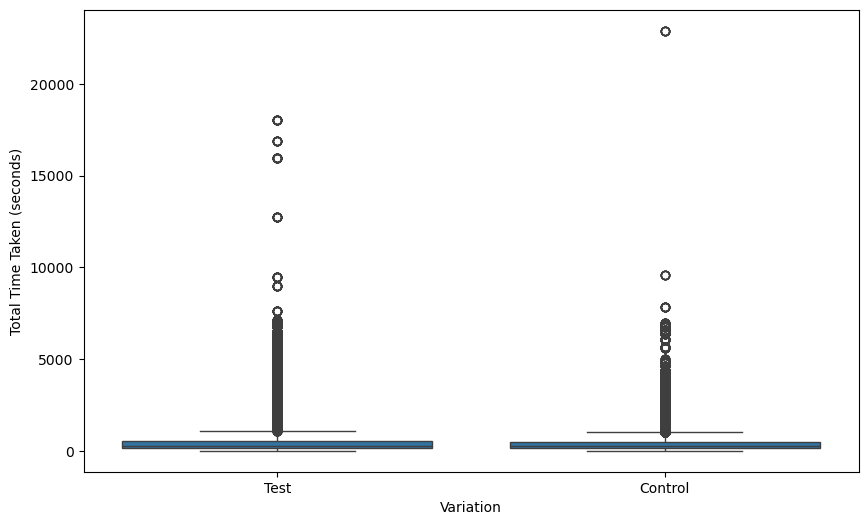

In [115]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='total_time_taken', data=visits_variations)
plt.xlabel('Variation')
plt.ylabel('Total Time Taken (seconds)')
plt.show()

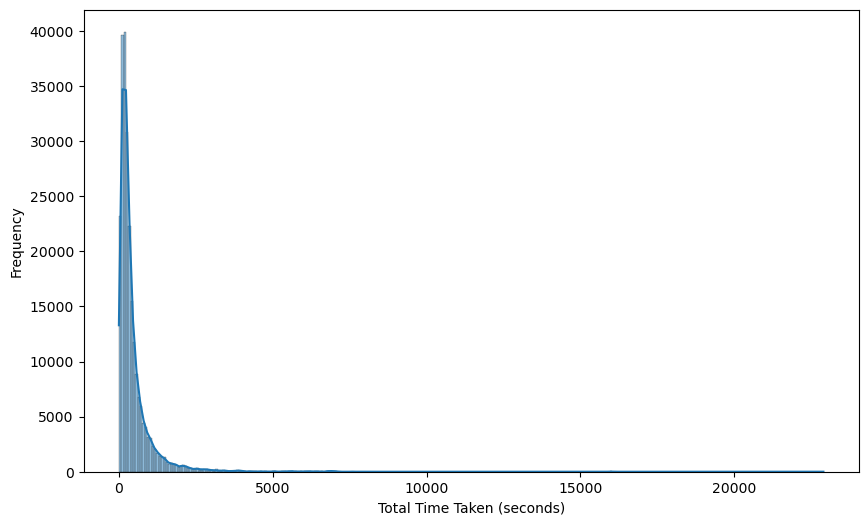

In [116]:
plt.figure(figsize=(10, 6))
sns.histplot(data=visits_variations, x='total_time_taken', kde=True, bins=300)
plt.xlabel('Total Time Taken (seconds)')
plt.ylabel('Frequency')
plt.show()

In [117]:
variations_outliers = tukeys_test_outliers(visits_variations['total_time_taken'], method="show")
display(variations_outliers)
display(variations_outliers.describe())

visits_variations = visits_variations[~visits_variations['total_time_taken'].isin(variations_outliers)]
display(visits_variations)
display(visits_variations.describe(include='all'))
display(visits_variations.dtypes)


275609    1183.0
275608    1183.0
275607    1183.0
275606    1183.0
275605    1183.0
           ...  
72154     2128.0
72153     2128.0
72152     2128.0
72151     2128.0
72150     2128.0
Name: total_time_taken, Length: 21313, dtype: float64

count    21313.000000
mean      2005.956083
std       1441.675624
min       1064.000000
25%       1247.000000
50%       1539.000000
75%       2168.000000
max      22895.000000
Name: total_time_taken, dtype: float64

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9,0.0,242.0
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,7,23,M,2,26436.73,6,9,16.0,242.0
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,7,23,M,2,26436.73,6,9,9.0,242.0
236487,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,88,7,23,M,2,26436.73,6,9,14.0,242.0
236486,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,88,7,23,M,2,26436.73,6,9,6.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,6,64,U,2,74783.76,5,8,0.0,1050.0
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,6,64,U,2,74783.76,5,8,68.0,1050.0
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,6,64,U,2,74783.76,5,8,38.0,1050.0
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,6,64,U,2,74783.76,5,8,101.0,1050.0


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
count,2.192270e+05,219227,219227,219227,219227,219227,219227.000000,219227.000000,219227.000000,219227,219227.000000,2.192270e+05,219227.000000,219227.000000,219227.000000,219227.000000
unique,NaN,45439,45541,5,NaN,2,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,857376424_12378092455,518285126_8572733997_709761,start,NaN,Test,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,88,88,68308,NaN,119871,NaN,NaN,NaN,76971,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.006738e+06,NaN,NaN,NaN,2017-04-19 16:13:51.755568384,NaN,148.476657,11.871407,46.582825,NaN,2.250156,1.467244e+05,3.078617,6.115164,49.218522,308.841995
min,5.550000e+02,NaN,NaN,NaN,2017-03-15 00:19:28,NaN,33.000000,2.000000,17.000000,NaN,1.000000,2.378944e+04,0.000000,3.000000,0.000000,0.000000
25%,2.515274e+06,NaN,NaN,NaN,2017-04-03 21:11:31.500000,NaN,81.000000,6.000000,33.000000,NaN,2.000000,3.950238e+04,1.000000,4.000000,4.000000,139.000000
50%,5.042117e+06,NaN,NaN,NaN,2017-04-12 11:59:49,NaN,132.000000,11.000000,47.000000,NaN,2.000000,6.459520e+04,3.000000,6.000000,21.000000,244.000000
75%,7.465118e+06,NaN,NaN,NaN,2017-04-28 10:44:16,NaN,190.000000,15.000000,59.000000,NaN,2.000000,1.365374e+05,5.000000,8.000000,60.000000,420.000000
max,9.999832e+06,NaN,NaN,NaN,2017-06-20 23:26:00,NaN,669.000000,55.000000,96.000000,NaN,7.000000,8.986420e+06,6.000000,9.000000,1044.000000,1063.000000


client_id                      int64
visitor_id                    object
visit_id                      object
process_step                category
date_time             datetime64[ns]
variation                   category
client_since_month             int64
client_since_year              int64
client_age                     int64
gender                      category
number_of_accounts             int64
balance                      float64
calls_6_months                 int64
logons_6_month                 int64
time_taken                   float64
total_time_taken             float64
dtype: object

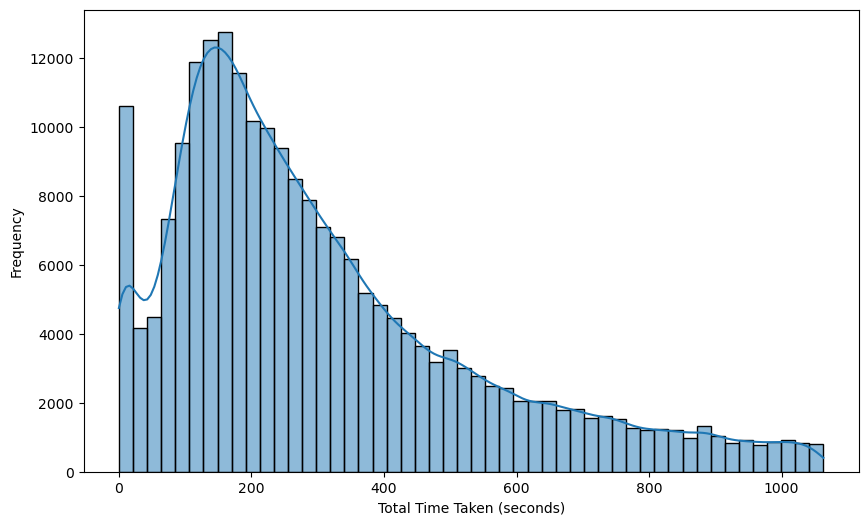

In [118]:
plt.figure(figsize=(10, 6))
sns.histplot(data=visits_variations, x='total_time_taken', kde=True, bins=50)
plt.xlabel('Total Time Taken (seconds)')
plt.ylabel('Frequency')
plt.show()

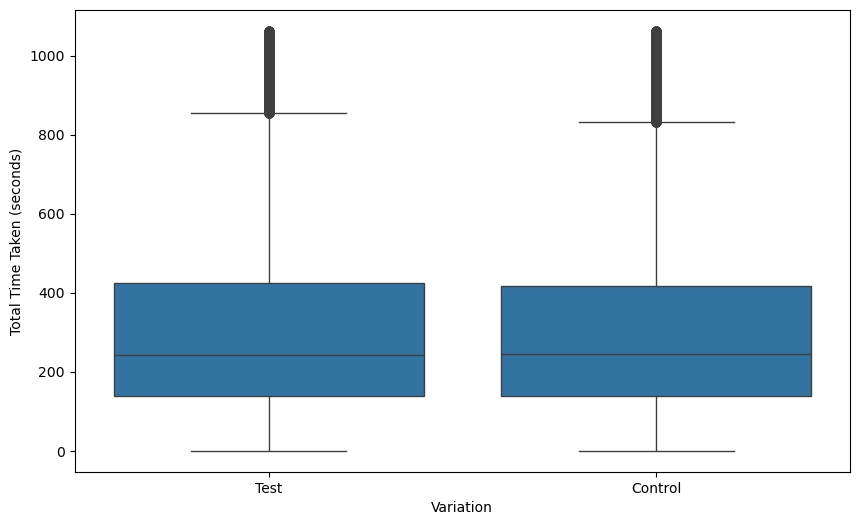

count    219227.000000
mean        308.841995
std         235.216060
min           0.000000
25%         139.000000
50%         244.000000
75%         420.000000
max        1063.000000
Name: total_time_taken, dtype: float64

In [119]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation', y='total_time_taken', data=visits_variations)
plt.xlabel('Variation')
plt.ylabel('Total Time Taken (seconds)')
plt.show()

visits_variations['total_time_taken'].describe()

In [120]:
cleaning.append({"step" : "Remove outliers", "count" : visits_variations['client_id'].nunique()})
display(cleaning)

[{'step': 'Raw data', 'count': 120157},
 {'step': 'Drop nulls', 'count': 100048},
 {'step': 'Remove unknown variation', 'count': 50487},
 {'step': 'Remove repeat and shared visits', 'count': 50109},
 {'step': 'Remove non-starters', 'count': 47914},
 {'step': 'Remove outliers', 'count': 45541}]

### Correlation matrix

,client_id,client_since_month,client_since_year,client_age,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
client_id,1.000000,0.006450,0.006616,-0.001127,-0.003384,-0.001807,-0.006098,-0.006139,0.002472,-0.000016
client_since_month,0.006450,1.000000,0.998916,0.307362,0.141323,0.202971,0.041712,0.046240,-0.003811,0.021543
client_since_year,0.006616,0.998916,1.000000,0.307066,0.141573,0.203726,0.043762,0.048325,-0.004052,0.021416
client_age,-0.001127,0.307362,0.307066,1.000000,-0.032729,0.207751,0.046172,0.054290,0.002021,0.122528
number_of_accounts,-0.003384,0.141323,0.141573,-0.032729,1.000000,0.260501,0.232742,0.236783,-0.004222,-0.027510
balance,-0.001807,0.202971,0.203726,0.207751,0.260501,1.000000,0.168945,0.175584,-0.004699,0.023122
calls_6_months,-0.006098,0.041712,0.043762,0.046172,0.232742,0.168945,1.000000,0.994836,0.004178,-0.039454
logons_6_month,-0.006139,0.046240,0.048325,0.054290,0.236783,0.175584,0.994836,1.000000,0.003959,-0.038028
time_taken,0.002472,-0.003811,-0.004052,0.002021,-0.004222,-0.004699,0.004178,0.003959,1.000000,0.035539
total_time_taken,-0.000016,0.021543,0.021416,0.122528,-0.027510,0.023122,-0.039454,-0.038028,0.035539,1.000000


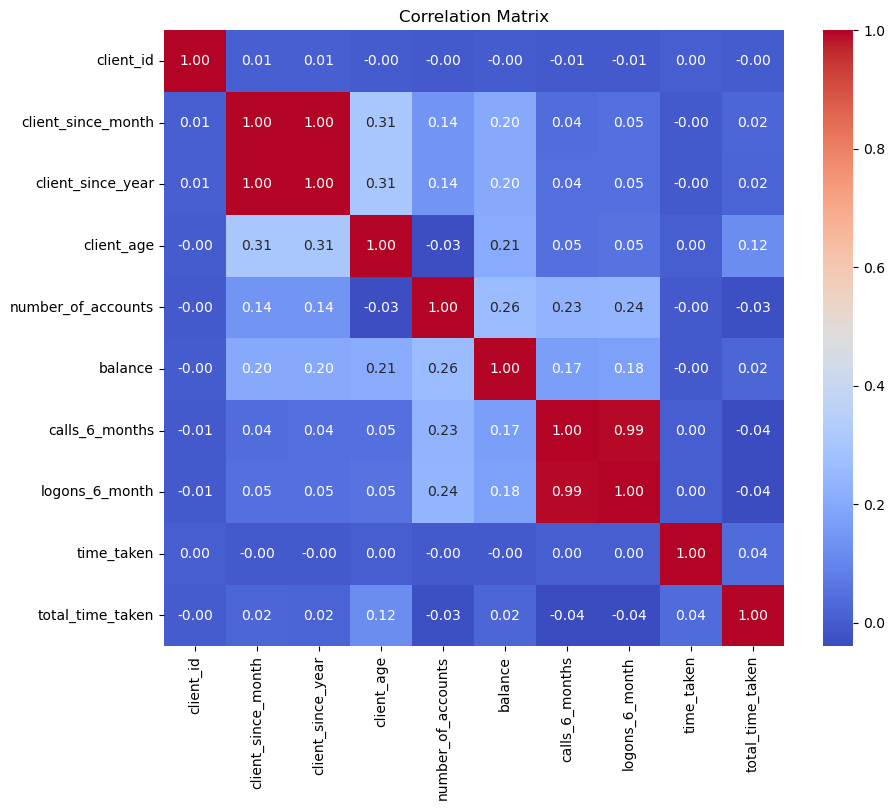

In [121]:
# select all clients
visits_by_client_ids = visits_variations.drop_duplicates(subset='client_id', keep='first')

# Select numerical columns
numerical_data = visits_by_client_ids.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Display the correlation matrix
display(correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Count visits

In [122]:
# Total number of visits per variation to calculate the success rate later
number_of_visits = visits_variations.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits)


variation
Test       23756
Control    21793
Name: visit_id, dtype: int64

### Time taken

In [123]:
# Average total time taken per variation
average_total_time_ = visits_variations.groupby('variation', observed=False)['total_time_taken'].mean()
display(average_total_time_)

variation
Test       310.752092
Control    306.537502
Name: total_time_taken, dtype: float64

## Happy Path

In [124]:
# function to filter visits with our happy path
def filter_visits_with_happy_path(df):
    def check_sequence(group):
        steps = list(group['process_step'])
        return steps == ['start', 'step_1', 'step_2', 'step_3', 'confirm']

    df_filtered = df.groupby('visit_id').filter(check_sequence)
    return df_filtered


In [125]:
happy_paths = filter_visits_with_happy_path(visits_variations)
display(happy_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
243695,2478628,754122351_18568832435,100022086_87870757897_149620,start,2017-05-23 20:44:01,Test,198,16,47,F,2,32456.28,2,5,0.0,180.0
243694,2478628,754122351_18568832435,100022086_87870757897_149620,step_1,2017-05-23 20:44:23,Test,198,16,47,F,2,32456.28,2,5,22.0,180.0
243693,2478628,754122351_18568832435,100022086_87870757897_149620,step_2,2017-05-23 20:45:08,Test,198,16,47,F,2,32456.28,2,5,45.0,180.0
243692,2478628,754122351_18568832435,100022086_87870757897_149620,step_3,2017-05-23 20:46:01,Test,198,16,47,F,2,32456.28,2,5,53.0,180.0
243691,2478628,754122351_18568832435,100022086_87870757897_149620,confirm,2017-05-23 20:47:01,Test,198,16,47,F,2,32456.28,2,5,60.0,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90971,4064969,110735946_42614968419,999985675_64610694964_443659,start,2017-04-20 09:45:18,Control,75,6,64,U,2,74783.76,5,8,0.0,1050.0
90970,4064969,110735946_42614968419,999985675_64610694964_443659,step_1,2017-04-20 09:46:26,Control,75,6,64,U,2,74783.76,5,8,68.0,1050.0
90969,4064969,110735946_42614968419,999985675_64610694964_443659,step_2,2017-04-20 09:47:04,Control,75,6,64,U,2,74783.76,5,8,38.0,1050.0
90968,4064969,110735946_42614968419,999985675_64610694964_443659,step_3,2017-04-20 09:48:45,Control,75,6,64,U,2,74783.76,5,8,101.0,1050.0


In [126]:
# Total number of success per variation
number_of_successes = happy_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_successes)

variation
Test       8950
Control    7687
Name: visit_id, dtype: int64

In [127]:
# calculate the success rate per variation
success_rate = number_of_successes / number_of_visits
display(success_rate)

variation
Test       0.376747
Control    0.352728
Name: visit_id, dtype: float64

In [128]:
cleaning.append({"step" : "Happy Path", "count" : happy_paths['client_id'].nunique()})

## Confused Path

In [129]:
# function to filter out visits with start->confirm but no happy path in between them
def filter_non_happy_path_visits(df):
    def check_non_consecutive(group):
        steps = list(group['process_step'])
        if steps[0] == 'start' and steps[-1] == 'confirm':
            if steps != ['start', 'step_1', 'step_2', 'step_3', 'confirm']:
                return True
        return False

    df_filtered = df.groupby('visit_id').filter(check_non_consecutive)
    return df_filtered

In [130]:
confused_paths = filter_non_happy_path_visits(visits_variations)
display(confused_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9,0.0,242.0
236489,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:12,Test,88,7,23,M,2,26436.73,6,9,16.0,242.0
236488,7338123,612065484_94198474375,100019538_17884295066_43909,step_2,2017-04-09 16:21:21,Test,88,7,23,M,2,26436.73,6,9,9.0,242.0
236487,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:35,Test,88,7,23,M,2,26436.73,6,9,14.0,242.0
236486,7338123,612065484_94198474375,100019538_17884295066_43909,step_1,2017-04-09 16:21:41,Test,88,7,23,M,2,26436.73,6,9,6.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209403,4449968,842902495_57580498240,999976049_95772503197_182554,step_1,2017-04-04 12:52:26,Test,252,21,53,F,4,124701.46,2,5,136.0,728.0
209402,4449968,842902495_57580498240,999976049_95772503197_182554,step_2,2017-04-04 12:53:01,Test,252,21,53,F,4,124701.46,2,5,35.0,728.0
209401,4449968,842902495_57580498240,999976049_95772503197_182554,step_3,2017-04-04 12:54:54,Test,252,21,53,F,4,124701.46,2,5,113.0,728.0
209400,4449968,842902495_57580498240,999976049_95772503197_182554,step_3,2017-04-04 12:59:35,Test,252,21,53,F,4,124701.46,2,5,281.0,728.0


In [131]:
number_of_visits_non_happy = confused_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits_non_happy)

variation
Test       5063
Control    3757
Name: visit_id, dtype: int64

In [132]:
success_rate_non_happy = number_of_visits_non_happy / number_of_visits
display(success_rate_non_happy)
# proportion of lost people is greater in test group.

variation
Test       0.213125
Control    0.172395
Name: visit_id, dtype: float64

In [133]:
cleaning.append({"step" : "Confused Path", "count" : confused_paths['client_id'].nunique()})

## Dropped Path

In [134]:
without_happy_path = visits_variations[~visits_variations['visit_id'].isin(happy_paths['visit_id'])]

dropped_paths = without_happy_path[~without_happy_path['visit_id'].isin(confused_paths['visit_id'])]
display(dropped_paths)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
235338,105007,676020267_36602664238,100030127_47967100085_936361,start,2017-03-22 11:07:49,Control,118,9,35,F,2,34897.47,3,6,0.0,0.0
27085,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:41:51,Control,202,16,78,M,2,146827.14,5,8,0.0,132.0
27084,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:43:16,Control,202,16,78,M,2,146827.14,5,8,85.0,132.0
27083,5623007,700426174_33289797318,100037962_47432393712_705583,step_1,2017-04-14 16:43:55,Control,202,16,78,M,2,146827.14,5,8,39.0,132.0
27082,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:44:03,Control,202,16,78,M,2,146827.14,5,8,8.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168370,2008582,921522470_94918863147,999892866_86068341010_555953,step_1,2017-04-05 11:13:31,Test,57,4,29,M,3,195326.48,6,9,6.0,204.0
168369,2008582,921522470_94918863147,999892866_86068341010_555953,step_2,2017-04-05 11:13:49,Test,57,4,29,M,3,195326.48,6,9,18.0,204.0
168368,2008582,921522470_94918863147,999892866_86068341010_555953,step_3,2017-04-05 11:14:41,Test,57,4,29,M,3,195326.48,6,9,52.0,204.0
117541,5169181,691607385_25408081395,999946542_2156804531_646216,start,2017-04-12 17:17:10,Test,82,6,43,U,2,44092.02,0,3,0.0,0.0


In [135]:
number_of_visits_error_path = dropped_paths.groupby('variation', observed=False)['visit_id'].nunique()
display(number_of_visits_error_path)

variation
Test        9743
Control    10349
Name: visit_id, dtype: int64

In [136]:
success_rate_error_paths = number_of_visits_error_path / number_of_visits
display(success_rate_error_paths)

variation
Test       0.410128
Control    0.474877
Name: visit_id, dtype: float64

In [137]:
cleaning.append({"step" : "Dropped Path", "count" : dropped_paths['client_id'].nunique()})
display(cleaning)


[{'step': 'Raw data', 'count': 120157},
 {'step': 'Drop nulls', 'count': 100048},
 {'step': 'Remove unknown variation', 'count': 50487},
 {'step': 'Remove repeat and shared visits', 'count': 50109},
 {'step': 'Remove non-starters', 'count': 47914},
 {'step': 'Remove outliers', 'count': 45541},
 {'step': 'Happy Path', 'count': 16637},
 {'step': 'Confused Path', 'count': 8828},
 {'step': 'Dropped Path', 'count': 20090}]

## EXPORT DATAFRAME FOR VISUALISATION

### Select unique ids

In [138]:
unique_clients_visits = visits_variations.drop_duplicates(subset='client_id')
display(unique_clients_visits)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9,0.0,242.0
243695,2478628,754122351_18568832435,100022086_87870757897_149620,start,2017-05-23 20:44:01,Test,198,16,47,F,2,32456.28,2,5,0.0,180.0
235338,105007,676020267_36602664238,100030127_47967100085_936361,start,2017-03-22 11:07:49,Control,118,9,35,F,2,34897.47,3,6,0.0,0.0
27085,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:41:51,Control,202,16,78,M,2,146827.14,5,8,0.0,132.0
1594,4823947,611052344_43146965242,100057941_88477660212_944512,start,2017-04-09 11:30:10,Control,86,7,52,U,2,47340.11,5,8,0.0,254.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181050,9498187,599653496_46358190244,999954858_74676709104_879685,start,2017-04-05 11:13:34,Test,60,5,21,U,2,31295.49,6,9,0.0,127.0
73134,8971313,520929316_99288864740,999958344_67534252886_39917,start,2017-04-15 00:34:32,Test,95,7,25,U,2,46555.07,6,9,0.0,147.0
8441,2979920,830229399_73416253406,999971096_28827267783_236076,start,2017-04-13 10:31:49,Test,138,11,28,F,2,83799.17,1,4,0.0,139.0
209404,4449968,842902495_57580498240,999976049_95772503197_182554,start,2017-04-04 12:50:10,Test,252,21,53,F,4,124701.46,2,5,0.0,728.0


### Add path column

In [139]:
# Add 'path' column to unique_clients_visits
unique_clients_visits.loc[:, 'path'] = 'dropped' 

# Update 'path' column for happy paths
unique_clients_visits.loc[unique_clients_visits['visit_id'].isin(happy_paths['visit_id']), 'path'] = 'happy'

# Update 'path' column for confused paths
unique_clients_visits.loc[unique_clients_visits['visit_id'].isin(confused_paths['visit_id']), 'path'] = 'confused'

display(unique_clients_visits)


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_59386/3334346322.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,client_id,visitor_id,visit_id,process_step,date_time,variation,client_since_month,client_since_year,client_age,gender,number_of_accounts,balance,calls_6_months,logons_6_month,time_taken,total_time_taken,path
236490,7338123,612065484_94198474375,100019538_17884295066_43909,start,2017-04-09 16:20:56,Test,88,7,23,M,2,26436.73,6,9,0.0,242.0,confused
243695,2478628,754122351_18568832435,100022086_87870757897_149620,start,2017-05-23 20:44:01,Test,198,16,47,F,2,32456.28,2,5,0.0,180.0,happy
235338,105007,676020267_36602664238,100030127_47967100085_936361,start,2017-03-22 11:07:49,Control,118,9,35,F,2,34897.47,3,6,0.0,0.0,dropped
27085,5623007,700426174_33289797318,100037962_47432393712_705583,start,2017-04-14 16:41:51,Control,202,16,78,M,2,146827.14,5,8,0.0,132.0,dropped
1594,4823947,611052344_43146965242,100057941_88477660212_944512,start,2017-04-09 11:30:10,Control,86,7,52,U,2,47340.11,5,8,0.0,254.0,dropped
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181050,9498187,599653496_46358190244,999954858_74676709104_879685,start,2017-04-05 11:13:34,Test,60,5,21,U,2,31295.49,6,9,0.0,127.0,confused
73134,8971313,520929316_99288864740,999958344_67534252886_39917,start,2017-04-15 00:34:32,Test,95,7,25,U,2,46555.07,6,9,0.0,147.0,confused
8441,2979920,830229399_73416253406,999971096_28827267783_236076,start,2017-04-13 10:31:49,Test,138,11,28,F,2,83799.17,1,4,0.0,139.0,confused
209404,4449968,842902495_57580498240,999976049_95772503197_182554,start,2017-04-04 12:50:10,Test,252,21,53,F,4,124701.46,2,5,0.0,728.0,confused


### Add helper columns

In [140]:
# Add a column to separate ages into quantile-based groups with similar sizes
unique_clients_visits['age_group'] = pd.qcut(unique_clients_visits['client_age'], q=3, labels=['Younger', 'Middle aged', 'Seniors'])
display(unique_clients_visits.groupby('age_group', observed=False)['client_age'].describe())

# Add a column to separate balance into quantile-based groups with similar sizes
unique_clients_visits['balance_group'] = pd.qcut(unique_clients_visits['balance'], q=3, labels=['Low Balance', 'Medium Balance', 'High Balance'])
display(unique_clients_visits.groupby('balance_group', observed=False)['balance'].describe())

# Add a column 'is_active' if the client called more than thrice or logged on more than six times
unique_clients_visits['is_active'] = (unique_clients_visits['calls_6_months'] >= 6) | (unique_clients_visits['logons_6_month'] >= 6)
display(unique_clients_visits['is_active'].value_counts())

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_59386/2500611121.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
Younger,15347.0,29.006842,4.900684,17.0,25.0,29.0,33.0,37.0
Middle aged,15252.0,47.033504,5.222779,38.0,43.0,47.0,52.0,55.0
Seniors,14942.0,64.414670,6.612759,56.0,59.0,63.0,68.0,96.0


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_59386/2500611121.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,count,mean,std,min,25%,50%,75%,max
balance_group,,,,,,,,
Low Balance,15180.0,34425.327307,6264.246422,23789.44,29268.5675,33847.89,39614.5500,46321.90
Medium Balance,15180.0,67699.102352,15397.096728,46325.24,54424.3375,64786.09,79313.8125,102001.33
High Balance,15181.0,335241.994777,444872.179152,102040.24,136866.6600,201103.89,356412.1700,8986419.77


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_59386/2500611121.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



is_active
True     25258
False    20283
Name: count, dtype: int64

### Export csv

In [141]:
#export to csv
unique_clients_visits.to_csv('data/unique_clients_visits.csv', index=False)

## Analysis

In [142]:
# PROPORTION Z TEST ----Happy Paths---- Proportion of successes is greater in Test group than in Control group
# H0: Proportion of complete steps in TEST group <= Proportion of complete steps in CONTROL group
# H1: Pt > Pc
alpha = 0.05

successes = [number_of_successes['Test'], number_of_successes['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

happy_results = proportions_ztest(successes, just_visits, alternative = "larger")
display(happy_results[0],happy_results[1])


5.318175941021329

5.24063465131602e-08

In [143]:
# PROPORTION Z TEST ----Non Happy Paths----
# H0: Proportion of complete steps in TEST group <= Proportion of complete steps in CONTROL group
# H1: Pt > Pc
alpha = 0.05

successes = [number_of_visits_non_happy['Test'], number_of_visits_non_happy['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

confused_results = proportions_ztest(successes, just_visits, alternative = "larger")
display(confused_results[0],confused_results[1])


10.989131002898143

2.155281347923626e-28

In [144]:
# PROPORTION Z TEST ----Error Paths---- 
# H0: Proportion of visits in TEST group >= Proportion of visits in CONTROL group
# H1: Pt < Pc
alpha = 0.05

successes = [number_of_visits_error_path['Test'], number_of_visits_error_path['Control']]
just_visits = [number_of_visits['Test'], number_of_visits['Control']]

error_results = proportions_ztest(successes, just_visits, alternative = "smaller")
display(error_results[0],error_results[1])


-13.902867447375662

3.0426854749703e-44

### T-Test for total time

In [145]:
# TWO SAMPLE T TEST ---- Average total_time of success is smaller in Test group than in Control group
import scipy.stats as st
# H0: average time it took to complete steps in test group is greater or equal to one in control group 
#       (Mean_time_test>=Mean_time_control)
# H1: average time it took to complete steps is less in test group than in control group 
#       (Mean_time_test<Mean_time_control)
alpha=0.05
df_test = happy_paths[happy_paths['variation']=='Test']['total_time_taken']
df_control = happy_paths[happy_paths['variation']=='Control']['total_time_taken']
st.ttest_ind(df_test,df_control, equal_var=False, alternative = 'less')

TtestResult(statistic=-36.32060949743314, pvalue=9.542950582460536e-287, df=78067.40883326299)

In [146]:
average_time_per_variation = happy_paths.groupby('variation').agg({'total_time_taken': 'mean'})
average_time_per_variation

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_59386/4127129962.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,total_time_taken
variation,
Test,231.912514
Control,275.262521


In [147]:
# average total time without outliers
avg_total_time = happy_paths['total_time_taken'].mean()
display(avg_total_time)

251.94205686121296

In [148]:
# TWO SAMPLE T TEST ---- Average total_time of success is smaller in Test group than in Control group
import scipy.stats as st
# H0: average time it took to complete steps in test group is greater or equal to one in control group 
#       (Mean_time_test>=Mean_time_control)
# H1: average time it took to complete steps is less in test group than in control group 
#       (Mean_time_test<Mean_time_control)
alpha=0.05
df_test = confused_paths[confused_paths['variation']=='Test']['total_time_taken']
df_control = confused_paths[confused_paths['variation']=='Control']['total_time_taken']
st.ttest_ind(df_test,df_control, equal_var=False, alternative = 'less')

TtestResult(statistic=5.897133165808121, pvalue=0.9999999981408997, df=60784.85035257793)

In [149]:
average_time_per_variation = confused_paths.groupby('variation').agg({'total_time_taken': 'mean'})
average_time_per_variation

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_59386/2527091129.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,total_time_taken
variation,
Test,439.773366
Control,428.878215


In [150]:
# average total time without outliers
avg_total_time = confused_paths['total_time_taken'].mean()
display(avg_total_time)

435.1294514818356

In [151]:
#TODO: funnel analysis
#TODO: stats on last step
#TODO: analyze repeat visits?

In [152]:
# STORY:

# 1. The data had the journeys of 108216 clients in 130607 visits.
    # We selected 

## Visualizations

## Conclusions

## Q

In [153]:
# hypothesis testing interpretation
# python debugging
# config file
# SQL to tableau
# boxplot not all outliers

In [154]:
import pandas as pd
import plotly.graph_objects as go

# Create a DataFrame with the data
data = pd.DataFrame({
    'Source': ['Raw Data', 'Removed Duplicates', 'Null Values Removed', 'Filtered Outliers', 'Filtered Outliers', 'Null Values Removed'],
    'Target': ['Removed Duplicates', 'Null Values Removed', 'Filtered Outliers', 'Final Clean Data', 'Outliers Discarded', 'Nulls Discarded'],
    'Value': [1000, 900, 800, 750, 50, 100]
})

# Create lists for the Sankey diagram
sources = data['Source'].tolist()
targets = data['Target'].tolist()
values = data['Value'].tolist()

# Create a list of unique labels for the nodes
all_nodes = list(set(sources + targets))
node_indices = {node: i for i, node in enumerate(all_nodes)}

# Map the source and target labels to their corresponding indices
source_indices = [node_indices[source] for source in sources]
target_indices = [node_indices[target] for target in targets]

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))
display(cleaning)
# Update the layout and display the diagram
fig.update_layout(title_text="Data Cleaning Process", font_size=12)
fig.show()

[{'step': 'Raw data', 'count': 120157},
 {'step': 'Drop nulls', 'count': 100048},
 {'step': 'Remove unknown variation', 'count': 50487},
 {'step': 'Remove repeat and shared visits', 'count': 50109},
 {'step': 'Remove non-starters', 'count': 47914},
 {'step': 'Remove outliers', 'count': 45541},
 {'step': 'Happy Path', 'count': 16637},
 {'step': 'Confused Path', 'count': 8828},
 {'step': 'Dropped Path', 'count': 20090}]

In [155]:
import pandas as pd
import plotly.graph_objects as go

# Create a DataFrame with the data
data = pd.DataFrame({
    'Source': ['Raw Data','All Clients', 'Drop nulls', 'Unknown variations', 'Repeats & shared', 'Non-starters', 'Outliers', 'Outliers', 'Outliers'],
    'Target': ['All Clients','Drop nulls', 'Unknown variations', 'Repeats & shared', 'Non-starters', 'Outliers', 'Happy Path', 'Confused Path', 'Dropped Path'],
    'Value': [120157, 100048, 50487, 50109, 47914, 45541, 16637, 8828, 20090]
})

# Create lists for the Sankey diagram
sources = data['Source'].tolist()
targets = data['Target'].tolist()
values = data['Value'].tolist()

# Create a list of unique labels for the nodes
all_nodes = list(set(sources + targets))
node_indices = {node: i for i, node in enumerate(all_nodes)}

# Map the source and target labels to their corresponding indices
source_indices = [node_indices[source] for source in sources]
target_indices = [node_indices[target] for target in targets]

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
))
display(cleaning)
# Update the layout and display the diagram with a transparent background
fig.update_layout(
    title_text="Data Cleaning Process",
    font_size=12,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

[{'step': 'Raw data', 'count': 120157},
 {'step': 'Drop nulls', 'count': 100048},
 {'step': 'Remove unknown variation', 'count': 50487},
 {'step': 'Remove repeat and shared visits', 'count': 50109},
 {'step': 'Remove non-starters', 'count': 47914},
 {'step': 'Remove outliers', 'count': 45541},
 {'step': 'Happy Path', 'count': 16637},
 {'step': 'Confused Path', 'count': 8828},
 {'step': 'Dropped Path', 'count': 20090}]

In [156]:
import pandas as pd
import plotly.graph_objects as go

# Create a DataFrame with the data
data = pd.DataFrame({
    'Source': ['Raw Data','All Clients', 'Drop nulls', 'Unknown variations', 'Repeats & shared', 'Non-starters', 'Outliers', 'Outliers', 'Outliers'],
    'Target': ['All Clients','Drop nulls', 'Unknown variations', 'Repeats & shared', 'Non-starters', 'Outliers', 'Happy Path', 'Confused Path', 'Dropped Path'],
    'Value': [120157, 100048, 50487, 50109, 47914, 45541, 16637, 8828, 20090]
})

# Create lists for the Sankey diagram
sources = data['Source'].tolist()
targets = data['Target'].tolist()
values = data['Value'].tolist()

# Create a list of unique labels for the nodes
all_nodes = list(set(sources + targets))
node_indices = {node: i for i, node in enumerate(all_nodes)}

# Map the source and target labels to their corresponding indices
source_indices = [node_indices[source] for source in sources]
target_indices = [node_indices[target] for target in targets]

# Define custom colors for nodes (using a list of colors)
node_colors = [
    "#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", 
    "#19D3F3", "#FF6692", "#B6E880", "#FF97FF", "#FECB52"
]

# Ensure node colors align with the all_nodes list length
node_colors = node_colors[:len(all_nodes)]

# Create the Sankey diagram with custom colors and values displayed
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=node_colors  # Assign custom colors to nodes
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        color="rgba(0,100,255,0.4)",  # Customize link colors (semi-transparent blue)
        # Add text for the links with values
        label=[f"{value}" for value in values],
        customdata=[f"{value}" for value in values],  # Use custom data to display value
        hovertemplate='Flow: %{value}'  # Show the value in hover text
    )
))

# Update the layout and display the diagram with a transparent background
fig.update_layout(
    title_text="Data Cleaning Process",
    font_size=12,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_font=dict(color="white"),  # Set title color to white for better contrast
    font_color="white"  # Set overall font color to white for labels
)

fig.show()

In [159]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create a DataFrame with the data
data = pd.DataFrame({
    'Source': ['Raw Data', 'All Clients', 'Drop nulls', 'Unknown variations', 'Repeats & shared', 'Non-starters', 'Outliers', 'Outliers', 'Outliers'],
    'Target': ['All Clients', 'Drop nulls', 'Unknown variations', 'Repeats & shared', 'Non-starters', 'Outliers', 'Happy Path', 'Confused Path', 'Dropped Path'],
    'Value': [120157, 100048, 50487, 50109, 47914, 45541, 16637, 8828, 20090]
})

# Create lists for the Sankey diagram
sources = data['Source'].tolist()
targets = data['Target'].tolist()
values = data['Value'].tolist()

# Create a list of unique labels for the nodes
all_nodes = list(set(sources + targets))
node_indices = {node: i for i, node in enumerate(all_nodes)}

# Map the source and target labels to their corresponding indices
source_indices = [node_indices[source] for source in sources]
target_indices = [node_indices[target] for target in targets]

# Define a gradient of teal colors using matplotlib
cmap = plt.get_cmap('winter')  # 'winter' colormap gives a teal-like gradient
gradient_colors = [mcolors.rgb2hex(cmap(i / (len(all_nodes) - 1))) for i in range(len(all_nodes))]

# Create the Sankey diagram with the teal gradient colors
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=gradient_colors  # Assign gradient colors to nodes
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        color="rgba(0,128,128,0.4)",  # Semi-transparent teal color for links
        label=[f"{value}" for value in values],
        customdata=[f"{value}" for value in values],  # Use custom data to display value
        hovertemplate='Flow: %{value}'  # Show the value in hover text
    )
))

# Update the layout and display the diagram with a transparent background
fig.update_layout(
    title_text="Data Cleaning Process",
    font_size=12,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_font=dict(color="white"),  # Set title color to white for better contrast
    font_color="white"  # Set overall font color to white for labels
)

fig.show()